# برنامه شبیه سازی صف بیمارستان
توی این برنامه سعی می کنیم حالت های مختلف صف در مسیر آی سی یو، اتاق عمل و بخش عمومی رو بررسی کنیم. ممکنه من مساله رو اشتباه فهمیده باشم ولی خیلی هم مهم نیست.

از نظر من مساله اینه: یک اتاق آی سی یو داریم با تعدادی تخت و یک بخش عمومی با تعدادی تخت. مسیر اینطوریه که اول بیمار با مشکل حاد به آی سی یو می رسه، بعد در صورتی که در بخش عمومی اتاق خالی داشته باشیم، عمل می شه و به بخش عمومی می ره و بعد از مدتی مرخص می شه.
    
شرایط اینهاست:
    
    - همیشه بیمار منتظر برای بستری شدن در آی سی یو هست
    - اگر در بخش تخت خالی نباشه نمی تونیم کسی رو عمل کنیم در نتیجه از آی سی یو کسی کم نمی شه
    - در ابتدای ورود به بخش یا آی سی یو، مشخص می شه که بیمار حداقل چند روز باید اینجا بمونه. تابع get_random_days اینکار رو انجام می ده و بر اساس یک تابع نرمال
    
کلیت سیستم بر اساس دو دیکشنری کار می کنه:
ward & icu
مثلا 
icu = {0: 3, 1:2, 3:0}
می گه که در آی سی یو سه تخت داریم که در اولی بیماری هست که باید ۳ روز دیگه در آی سی یو بمونه، در دومی بیماری هست که باید ۲ روز در آی سی یو بمونه و در سومی بیماری نیست.

نکته: من فکر می کردم بعد از جراحی هم می رن تو آی سی یو ولی شاید این مساله در تعداد روزهای نیازمند بستری دیده شده و شاید هم نمی رن. به هرحال این یه تمپلیت است و بیمارستان می تونه بنا به نیاز خودش تغییرش بده و تنظیمش کنه

ویدئوی آموزشی این نوت بوک رو از اینجا ببینین: 
[https://www.youtube.com/watch?v=jRASorLrZH4](https://www.youtube.com/watch?v=jRASorLrZH4)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

مشخص کردن تعداد روزهایی که باید شبیه سازی بشن و تعداد اتاق های مختلفی که می خوایم بررسی کنیم. 

In [3]:
TOTAL_DAYS = 365

BEDS = [(7, 10), (10, 10), (12, 10), (7, 12)] # Four pairs of (WARD, ICU) beds

In [120]:
def empty_bed(room): #is there an empty bed in this room?
    for bed in room:
        if room[bed] == 0:
            return True
    return False

def get_random_days(room): # returns random days for ward or icu. changes the formulas as required
    if room == 'ward':
        days = np.round((np.random.normal(3)+1))
    elif room == 'icu':
        days = np.round((np.random.normal(3)+1))
    else:
        days = np.round((np.random.normal(3)+1))
    if days < 1:
        days = 1
    return days

def add_to_ward(): # add one patient to the ward room. we are sure that there is an empty room there
    for i in range(len(ward)):
        if ward[i] == 0:
            ward[i] = get_random_days('ward')
            return


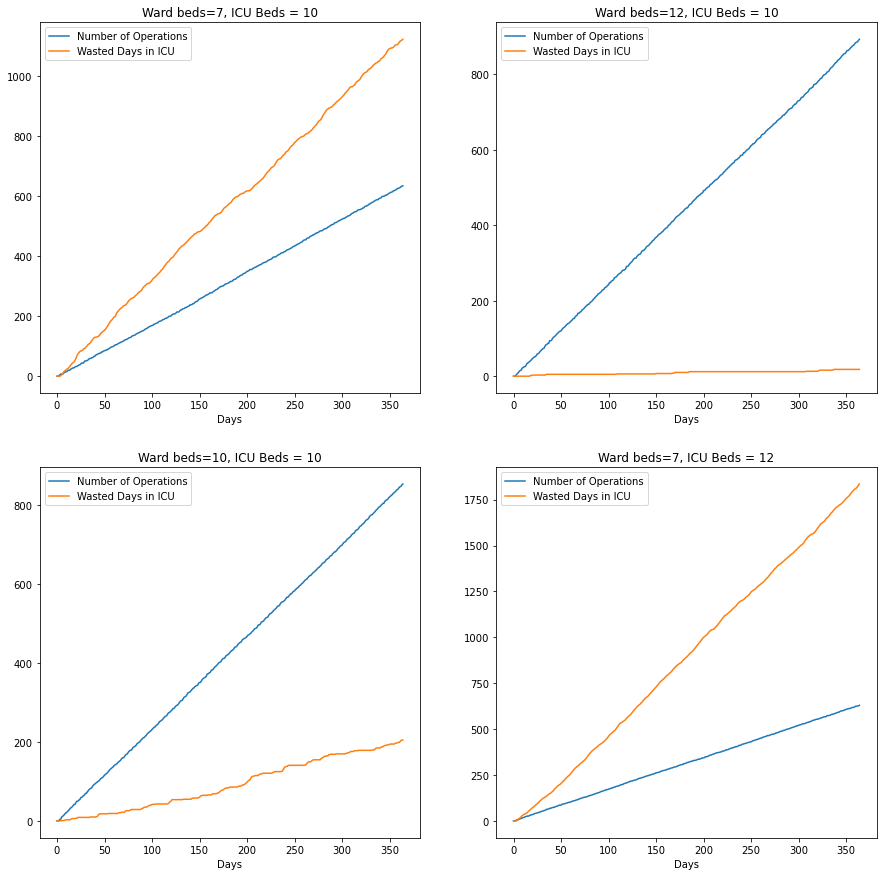

In [121]:
chart_counter = 0

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))


for beds in BEDS: # simulate for each WARD, ICU beds pair
    WARD_BEDS, ICU_BEDS = beds
    
    icu = { key: 0 for key in range(ICU_BEDS)} # empty the ICU
    ward = { key: 0 for key in range(WARD_BEDS)} # empty the Ward
    wasted = np.zeros(TOTAL_DAYS) # number of patients waiting in ICU because there is no bed in WARD
    surgery = np.zeros(TOTAL_DAYS) # number of patients went under surgery and moved from ICU to WARD
    
    for day in range(TOTAL_DAYS): # each iteration is simulating one day in the hospital
#         for i in range(len(icu)): # if we have an empty bed in ICU, add a patient there.
#             if icu[i] == 0:
#                 icu[i] = get_random_days('icu')
                
#         for i in range(len(icu)): # then we check the ICU patients and process them.
#             if icu[i] > 1: # if needs to stay more, just deduct one day
#                 icu[i] -= 1
#             else:  # other wise, if there is an empty bed in ward, do the surgery and move the patient to ward
#                 if empty_bed(ward):
#                     surgery[day] += 1
#                     icu[i] = 0
#                     add_to_ward()
#                 else:
#                     wasted[day] += 1

#         for i in range(len(ward)): # process the ward: reduce one day from stay time.
#             if ward[i] >= 1:
#                 ward[i] -= 1


#         the original for loop is as above (commented); However, I think it is more realistic and efficinet
#         to change the order of these operations.
#         I think we should process the WARD, at first. because it may result in a discharged bed (0)
#         This empty bed should be used as a sign for a new surgery "in the same day"
#         Also, checking for empty ICU beds should be processed at the end,
#         because some beds in ICU might have become free in the same day (as a new surgery takes place)
#         and this free icu bed should be filled in the same day - rather than the day after.

        for i in range(len(ward)): # process the ward: deduct one day from stay time.
            if ward[i] >= 1:
                ward[i] -= 1

        for i in range(len(icu)): # then we check the ICU patients and process them.
            if icu[i] > 1: # if needs to stay more, just deduct one day
                icu[i] -= 1
            elif icu[i] ==1:  # other wise, if there is an empty bed in ward, do the surgery and move the patient to ward
            # There are 2 reasons for changing the original "else" to "elif icu[i] ==1":
            # 1- The order of operations in the main for loop is revised, therfore icu beds with "0" value are not excluded prior to this part.
            # 2- If someday, we want to simulate a situation in which there is no patient in the ICU waiting-list,
            # we might want to let the beds to stay free, and excluded from being processed at this part.
                if empty_bed(ward):
                    surgery[day] += 1
                    icu[i] = 0
                    add_to_ward()
                else:
                    wasted[day] += 1
                    
        for i in range(len(icu)): # if we have an empty bed in ICU, add a patient there.
            if icu[i] == 0:
                icu[i] = get_random_days('icu')

                
    # draw chart for this ICU & Ward bed count pair
    chart_x = chart_counter % 2
    chart_y = int(chart_counter / 2)
    chart_counter += 1
                
    ax[chart_x][chart_y].plot(np.cumsum(surgery)) # draw comulative sums
    ax[chart_x][chart_y].plot(np.cumsum(wasted))  # draw comulative sums
    ax[chart_x][chart_y].set_xlabel("Days")
    ax[chart_x][chart_y].set_title(f"Ward beds={WARD_BEDS}, ICU Beds = {ICU_BEDS}")
    ax[chart_x][chart_y].legend(('Number of Operations', 'Wasted Days in ICU'))
    
plt.show()            

In [199]:
class simulation: # Defining a "class" for the simulation process, in order to use the benefits of OOP.
    def __init__(self, days, beds): # each "simulation" can be created using 2 arguments: "days" & "beds".                       
        self.days = days
        self.beds = beds
    
    def simulate(self, needResult): # needResult should be 0 (if you don't need the results to be printed) or 1 (if you need).
        
        # bellow are the inner functions.
        def empty_bed(room): #is there an empty bed in this room?
            for bed in room:
                if room[bed] == 0:
                    return True
            return False

        def get_random_days(room): # returns random days for ward or icu. changes the formulas as required
            if room == 'ward':
                days = np.round((np.random.normal(3)+1))
            elif room == 'icu':
                days = np.round((np.random.normal(3)+1))
            else:
                days = np.round((np.random.normal(3)+1))
            if days < 1:
                days = 1
            return days

        def add_to_ward(): # add one patient to the ward room. we are sure that there is an empty room there
            for i in range(len(ward)):
                if ward[i] == 0:
                    ward[i] = get_random_days('ward')
                    return
        
        # Bellow, is the same for-loop as previous.
        BEDS= self.beds
        TOTAL_DAYS= self.days
        
        for beds in BEDS: # simulate for each WARD, ICU beds pair
            WARD_BEDS, ICU_BEDS = beds

            icu = { key: 0 for key in range(ICU_BEDS)} # empty the ICU
            ward = { key: 0 for key in range(WARD_BEDS)} # empty the Ward
            wasted = np.zeros(TOTAL_DAYS) # number of patients waiting in ICU because there is no bed in WARD
            surgery = np.zeros(TOTAL_DAYS) # number of patients went under surgery and moved from ICU to WARD

            for day in range(TOTAL_DAYS): # each iteration is simulating one day in the hospital
                
                for i in range(len(ward)): # process the ward: deduct one day from stay time.
                    if ward[i] >= 1:
                        ward[i] -= 1

                for i in range(len(icu)): # then we check the ICU patients and process them.
                    if icu[i] > 1: # if needs to stay more, just deduct one day
                        icu[i] -= 1
                    elif icu[i] == 1:# other wise, if there is an empty bed in ward, do the surgery and move the patient to ward
                        if empty_bed(ward):
                            surgery[day] += 1
                            icu[i] = 0
                            add_to_ward()
                        else:
                            wasted[day] += 1
                            

                for i in range(len(icu)): # if we have an empty bed in ICU, add a patient there.
                    if icu[i] == 0:
                        icu[i] = get_random_days('icu')
                
                if needResult == 1:
                    print(f">>> DAY {day+1} ****** {WARD_BEDS} Ward-beds & {ICU_BEDS} ICU-beds ******")
                    print("* ICU=  ", np.fromiter(icu.values(), dtype=int))
                    print("* WARD= ", np.fromiter(ward.values(), dtype=int))
                    print("* wasted=  ", wasted.astype(int))
                    print("* surgery= ", surgery.astype(int))
                elif needResult == 0:
                    print("You choosed not to see the results!")
                else:
                    print("You should choose wheather to see the results or not by using '1' or '0'")
            if needResult == 1:
                print("==================================================")
                    

In [200]:
new_beds = [(10,12),(8,10)]
sim1 = simulation(10, new_beds)
sim1.simulate(1)

>>> DAY 1 ****** 10 Ward-beds & 12 ICU-beds ******
* ICU=   [3 4 4 7 4 5 5 3 4 6 3 3]
* WARD=  [0 0 0 0 0 0 0 0 0 0]
* wasted=   [0 0 0 0 0 0 0 0 0 0]
* surgery=  [0 0 0 0 0 0 0 0 0 0]
>>> DAY 2 ****** 10 Ward-beds & 12 ICU-beds ******
* ICU=   [2 3 3 6 3 4 4 2 3 5 2 2]
* WARD=  [0 0 0 0 0 0 0 0 0 0]
* wasted=   [0 0 0 0 0 0 0 0 0 0]
* surgery=  [0 0 0 0 0 0 0 0 0 0]
>>> DAY 3 ****** 10 Ward-beds & 12 ICU-beds ******
* ICU=   [1 2 2 5 2 3 3 1 2 4 1 1]
* WARD=  [0 0 0 0 0 0 0 0 0 0]
* wasted=   [0 0 0 0 0 0 0 0 0 0]
* surgery=  [0 0 0 0 0 0 0 0 0 0]
>>> DAY 4 ****** 10 Ward-beds & 12 ICU-beds ******
* ICU=   [4 1 1 4 1 2 2 4 1 3 5 4]
* WARD=  [4 3 4 4 0 0 0 0 0 0]
* wasted=   [0 0 0 0 0 0 0 0 0 0]
* surgery=  [0 0 0 4 0 0 0 0 0 0]
>>> DAY 5 ****** 10 Ward-beds & 12 ICU-beds ******
* ICU=   [3 5 4 3 4 1 1 3 4 2 4 3]
* WARD=  [3 2 3 3 4 4 5 6 0 0]
* wasted=   [0 0 0 0 0 0 0 0 0 0]
* surgery=  [0 0 0 4 4 0 0 0 0 0]
>>> DAY 6 ****** 10 Ward-beds & 12 ICU-beds ******
* ICU=   [2 4 3 2 3 4 5 